# Credit Card Fraud Detection

Credit card fraud represents a significant problem for financial institutions, and reliable fraud detection is generally challenging. Here we demonstrate how to train a machine learning model on a real-world credit card fraud dataset, and how to employ techniques like oversampling and threshold moving to address class imbalance.

Historically, fraud detection has been performed by analysts who are responsible for identifying and tracing suspicious patterns in the data. The rapid increase of online transactions, often associated with online shopping, mobile payments etc., has made this approach unfeasible. A modern transaction dataset has hundreds of dimensions, millions of records, and is constantly updated in an online fashion. Auxiliary techniques like relying on card holders to report fraudulent transactions have unfortunately proven to be ineffective [[1]](#ref1). 

Automated credit card fraud detection is generally implemented using one of the following methods:

* **Rule-based detection** - based on hard-coded rules, this approach requires a substantial amount of manual work to define the majority of the possible fraud conditions and to put rules in place that trigger alarms or block the suspicious transaction. An advantage of this approach is that its decisions are inherently explainable - it is straightforward to identify the rule, which flagged a specific transaction as fraudulent. The drawbacks are that rule-based detection is computationally intensive and is usually implemented as batch (or offline) scoring. Keeping the rules updated and constantly scanning for false negatives that slip through the cracks is also challenging from a maintenance perspective.

* **Machine Learning-based detection** - using statistical learning is another approach that is gaining popularity, mostly because it is less laborious. It can be implemented as either unsupervised (e.g. anomaly detection) or supervised model (classification), and requires less maintenance as the model can be automatically retrained to keep its associations up to date. It is also suitable for online applications, as the scoring function is usually very lightweight. A drawback of the ML approach is that there for certain algorithms (e.g. deep learning) there is no guaranteed explainability.

In this notebook we will show an implementation of an ML-based anomaly detection based on XGBoost. We will go through a typical ML pipeline, where we do data ingestion, exploratory data analysis, feature engineering, model training and evaluation. 


## Table of contents
1. [Data Ingestion](#data)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#fe)
    1. [Oversampling](#oversampling)
4. [Model training](#model-training)
5. [Model evaluation](#model-evaluation)
6. [Persisting the model](#persisting)
7. [Summary](#summary)
8. [References](#ref)

## Data Ingestion <a name="data"></a>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix

from sklearn import metrics

from datetime import datetime

%matplotlib inline

We start by reading and inspecting the complete dataset. This dataset contains anonymized credit card transaction data and is freely available from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). The data has been collected as part of a research collaboration between Worldline and the Machine Learning Group of [Université Libre de Bruxelles](http://mlg.ulb.ac.be).
The dataset contains transactions made by European credit card holders in September 2013, and has been anonymized - Features V1, V2, ..., V28 are results from applying PCA on the raw data. The only intact features are Time and Amount. The class label is titled Class where 0 denotes a genuine transaction and 1 signifies fraud.

In [2]:
dataDF = pd.read_csv("dataset/creditcard.csv")
dataDF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
dataDF.shape

(284807, 31)

## Exploratory Data Analysis <a name="eda"></a>

In [4]:
print("The dataset contains %d samples in total." % len(dataDF))

The dataset contains 284807 samples in total.


Next, let's check for missing values.

In [5]:
dataDF.isnull().any().any()

False

It appears that there are no missing values, however, as card transaction datasets usually contain mostly normal transactions and just a small fraction of fraudulent ones, our expectation is that the dataset will be highly unbalanced. We can confirm this by checking the distribution of the target classes.

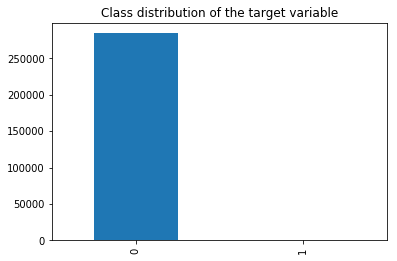

In [6]:
value_counts = dataDF["Class"].value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target variable");

In [7]:
print("Fraudulent transactions are %.2f%% of the complete dataset." % (value_counts[1] * 100 / value_counts[0]))

Fraudulent transactions are 0.17% of the complete dataset.


As expected, the majority of the samples are legitimate transactions. Only 0.17% of the transactions are flagged as fraudulent.

Let's also look at the basic descriptive statistics for all attributes.

In [8]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
dataDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


Inspecting the statistics above reveals that the V1-V28 attributes are zero-centered, but this is not the case for the other two input attributes Time and Amount. 

In [9]:
dataDF[["Amount", "Time"]].describe()

,Amount,Time
count,284807.000,284807.000
mean,88.350,94813.860
std,250.120,47488.146
min,0.000,0.000
25%,5.600,54201.500
50%,22.000,84692.000
75%,77.165,139320.500
max,25691.160,172792.000


We can also plot the histograms for all input attributes and make sure nothing unusual stands out.

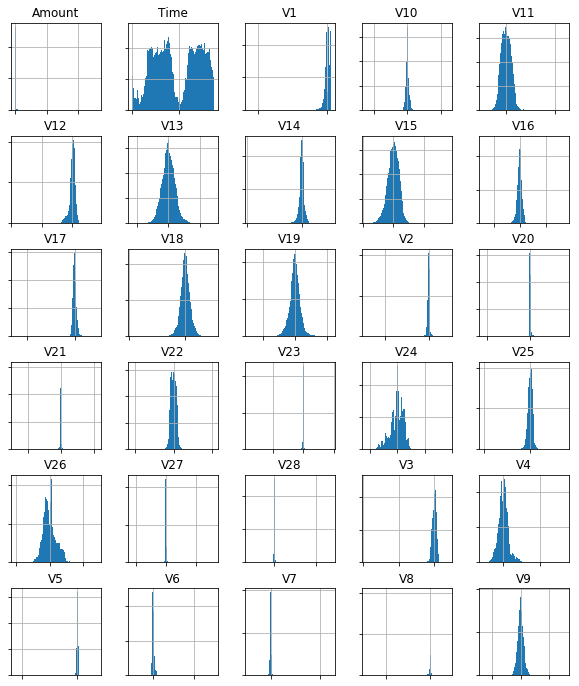

In [10]:
ax = dataDF.drop("Class", axis=1).hist(figsize=(10,12),bins=100)
# We can hide the axes' labels to make the plot neater and more compact 
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

There isn't much we can do about the principal components, but it looks like the Amount and Time attributes deserve a more detailed inspection.

First of all, the basic statistics for Time suggest that this attribute is given as a timestamp (seconds). We can convert it to local date and extract the hours in an attempt to identify if the hour of the transaction is correlated with the possibility of a transaction being fraudulent.

In [11]:
dataDF["Hour"] = dataDF["Time"].apply(datetime.fromtimestamp).dt.hour

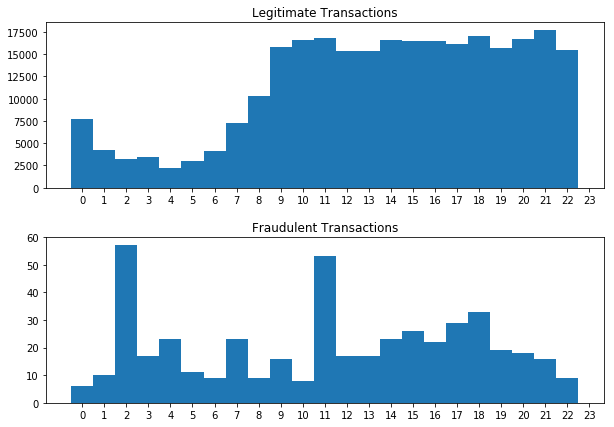

In [12]:
fig, ax = plt.subplots(2, figsize=(10,7))
for a in ax:
    a.set_xticks(range(24))
dataDF.loc[dataDF["Class"] == 0]["Hour"].hist(bins=np.arange(24)-0.5, ax=ax[0], grid=False)
dataDF.loc[dataDF["Class"] == 1]["Hour"].hist(bins=np.arange(24)-0.5, ax=ax[1], grid=False)
ax[0].title.set_text("Legitimate Transactions")
ax[1].title.set_text("Fraudulent Transactions")
plt.subplots_adjust(hspace=0.3)

It appears that the legitimate transactions plunge during the night and their rate increases with the start of the working day. In contrast, there is a peak of fraudulent transactions at around 2am that looks unusual. In addition, the data for the fraudulent transactions looks more evenly spread. Let's write a simple function that will allow us to compare the basic statistics for a single attribute across the fraud/no-fraud classes.

In [13]:
def compare_leg_fraud(attribute):
    leg_trS = dataDF.loc[dataDF["Class"] == 0][attribute].rename("Legitimate").describe()
    frd_trS = dataDF.loc[dataDF["Class"] == 1][attribute].rename("Fraudulent").describe()
    tr_hourDF = leg_trS.to_frame().join(frd_trS.to_frame())
    return tr_hourDF
    
compare_leg_fraud("Hour")

,Legitimate,Fraudulent
count,284315.000,492.000
mean,14.051,11.646
std,5.833,6.663
min,0.000,0.000
25%,10.000,5.000
50%,15.000,12.000
75%,19.000,17.000
max,23.000,23.000


The fraudulent transactions definitely have a higher standard deviation, but given their relatively low number we can't be certain if this is a genuine pattern or just a statistical coincidence.

We now shift our attention to the transaction amount. Let's visualise the distribution of fraudulent vs legitimate transactions via histograms.

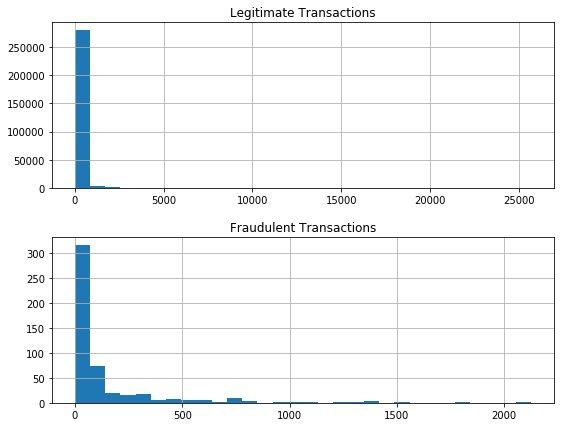

In [14]:
fig, ax = plt.subplots(2, figsize=(9,7))
dataDF.loc[dataDF["Class"] == 0]["Amount"].hist(bins=30, ax=ax[0])
dataDF.loc[dataDF["Class"] == 1]["Amount"].hist(bins=30, ax=ax[1])
ax[0].title.set_text("Legitimate Transactions")
ax[1].title.set_text("Fraudulent Transactions")
plt.subplots_adjust(hspace=0.3);

Let's also look at the basic statistics for the Amount attribute.

In [15]:
compare_leg_fraud("Amount")

,Legitimate,Fraudulent
count,284315.000,492.000
mean,88.291,122.211
std,250.105,256.683
min,0.000,0.000
25%,5.650,1.000
50%,22.000,9.250
75%,77.050,105.890
max,25691.160,2125.870


It looks like the mean transaction amount is higher for fraudulent transactions, although the overall amount is significantly lower in absolute terms. We can also look at the top 5 most frequent legitimate transactions. 

In [16]:
(dataDF.loc[dataDF["Class"] == 0]["Amount"].value_counts(normalize=True)*100).head()

1.000    4.775
1.980    2.126
0.890    1.714
9.990    1.669
15.000   1.154
Name: Amount, dtype: float64

versus the top 5 fraudulent transactions.

In [17]:
(dataDF.loc[dataDF["Class"] == 1]["Amount"].value_counts(normalize=True)*100).head()

1.000    22.967
0.000     5.488
99.990    5.488
0.760     3.455
0.770     2.033
Name: Amount, dtype: float64

We see that nearly 23% of all fraudulent transactions amount to 1.0, where the percentage for the same transaction amount in the legitimate set is closer to 5%. We also see a large number of 0-value transactions, which is probably the result of a cardholder details verification transactions.

## Feature Engineering <a name="fe"></a>

The first thing we'll do before we attempt any feature engineering is to create a holdout set. This is to prevent any information leakage into our test set. 

In [18]:
trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=1234, stratify=dataDF[["Class"]])

tr_value_counts = trainDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the training set." % (tr_value_counts[1] * 100 / len(trainDF)))

tst_value_counts = testDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (tst_value_counts[1] * 100 / len(testDF)))

Fraudulent transactions are 0.17% of the training set.
Fraudulent transactions are 0.17% of the test set.


We noticed during the exploratory analysis that the Amount column is not zero mean centered. Let's fix this, and also center the Hour attribute, which we'll be using instead of Time.

In [19]:
trainDF_norm = trainDF.copy()

trainDF_norm["Amount"] = trainDF["Amount"].subtract(trainDF["Amount"].mean())
trainDF_norm["Hour"] = trainDF["Hour"].subtract(trainDF["Hour"].mean())


testDF_norm = testDF.copy()

testDF_norm["Amount"] = testDF["Amount"].subtract(testDF["Amount"].mean())
testDF_norm["Hour"] = testDF["Hour"].subtract(testDF["Hour"].mean())

trainDF = trainDF_norm
testDF = testDF_norm

Next, we drop the Time attribute as we will be using Hour instead.

In [20]:
trainDF = trainDF.drop(["Time"], axis=1)
testDF = testDF.drop(["Time"], axis=1)

Now let's split the independent and the class variables into separate data frames.

In [21]:
X_train = trainDF.iloc[:, trainDF.columns != "Class"]
y_train = trainDF.iloc[:, trainDF.columns == "Class"]
X_test = testDF.iloc[:, testDF.columns != "Class"]
y_test = testDF.iloc[:, testDF.columns == "Class"]

In [22]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
135152,1.082,-0.075,1.395,1.373,-0.958,0.077,-0.625,0.205,0.861,-0.248,...,-0.012,0.204,0.063,0.399,0.298,-0.400,0.089,0.039,-76.750,7.946
103706,1.013,0.188,1.615,2.594,-0.609,0.839,-0.683,0.400,-0.260,0.597,...,0.017,0.218,0.074,0.230,0.185,-0.046,0.059,0.027,-81.450,4.946
231651,-0.701,0.090,1.540,-3.114,0.458,0.431,0.183,0.195,-1.230,-0.503,...,-0.069,-0.367,-0.449,-1.461,0.628,-0.475,0.004,0.027,-76.250,1.946
199939,-0.430,-0.595,0.676,-2.603,1.499,4.231,-1.079,1.239,-0.798,-0.003,...,-0.015,0.214,0.090,0.694,-0.698,0.592,0.158,0.166,-42.350,-1.054
103404,1.296,1.011,-3.192,0.472,3.350,2.433,0.190,0.622,-0.557,-1.487,...,-0.263,-0.825,-0.245,0.675,1.011,-0.279,0.041,0.091,-83.260,4.946


### Oversampling <a name="oversampling"></a>

We have already established that the original dataset is highly imbalanced. This is generally problematic, as the model trained on such data will have difficulties recognising the minority class. This becomes an even bigger problem when we are not interested in just predicting the outcome (we know that if we assume that a transaction is not fraudulent we will be correct in 99.83% of the time), but detecting instances of the minority class (e.g. fraud).

There are two common techniques for addressing class imbalance that are often used in practice, and both introduce bias into the dataset in order to equalize the representation of all classes.

* **Undersampling** - undersampling techniques remove observation from the dominant class to reduce the overrepresented/underrepresented gap. Random undersampling, for example, randomly removes samples (with or without replacement), quite often until the number of observations in the majority class becomes identical to the number of observations in the minority class.
* **Oversampling** - oversampling also aims to reduce the class counts discrepancy, but unlike undersampling it achieves this by increasing the number of instances in the minority class. There are different approaches to this strategy, with the two most commonly used being random oversampling and SMOTE. Random oversampling is a fairly straightforward solution, which simply makes multiple copies of existing minority class observations, thus increasing the number of total observations from the minority class. Synthetic Minority Over-sampling Technique (SMOTE), on the other hand, oversamples the minority class by creating synthetic examples. It has been shown that SMOTE outperforms simple undersampling [[2]](#ref2)

Using SMOTE to rectify the imbalance in our dataset is fairly easy, thanks to [imbalanced-learn](https://pypi.org/project/imbalanced-learn/), a Python package offering a number of re-sampling techniques, including SMOTE.

In [23]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)

In [24]:
smote_value_counts = y_train_smote["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Fraudulent transactions are 50.00% of the test set.


Now that the class imbalance has been resolved, we can move forward with the actual model training.

## Model training <a name="model-training"></a>

We will now train an XGBoost classifier, using the oversampled training set. First, we define a function that will perform a grid search for the optimal hyperparameters of the classifier. The highlights of the function are as follows:

* We do a parameter search over the hyperparameters given in *params*
* The cross-validation strategy for each model uses 3 folds in a stratified KFold
* The metric the models in the search are evaluated on is the Area Under the Receiver Operating Characteristic Curve (ROC AUC)
* The function prints the parameters that yield the highest AUC score and returns the parameters of the best estimator as its output

In [25]:
def xgboost_search(X, y, search_verbose=1):
    
    params = {
        "gamma":[0.5, 1, 1.5, 2, 5],
        "max_depth":[3,4,5,6],
        "min_child_weight": [100],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.1, 0.01, 0.001]
    }
    
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    
    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_) 
    print("Highest AUC: %.2f" % grid_search.best_score_)
    
    return grid_search.best_params_

As the training set is quite large, we limit the grid search to a sample of 5000 observations. After *xgboost_search* goes through all possible estimators it will print the parameters used for the best performing one, and will return an XGBClassifier object that we can use to check how well the model generalises. 

Note, that although we are using a relatively small subset of the training data, the search still needs to train over 1,600 models, and this will take awhile.

In [26]:
rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
model_params = xgboost_search(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.99


Now that we have the set of parameters that produces the highest score, we can use them to train a model on the complete oversampled training set.

In [27]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

## Model evaluation <a name="model-evaluation"></a>

We will use an ROC AUC curve for evaluating how well our model performs on the holdout set (X_test, y_test). To generate the ROC curve we calculate the true positive (TP) and false positive (FP) rates on the holdout set at various threshold levels.

Calling *predict_proba(X_test)\[:,1\]* on the holdout set will give us the estimated probability $\hat{Y_i}$ of a sample $\text{X_test}_i$ being in class 1 (fraud). Given a specific threshold $T$, we can classify $\text{X_test}_i$ as fraud if $T>\hat{Y_i}$. It is evident that varying $T$ impacts the TP/FP rates, and this is what the ROC curve represents.

We also show the Area Under the Curve (AUC) on the plot, as it is equal to the probability the model will rank a uniformly drawn random positive higher than a uniformly drawn random negative.

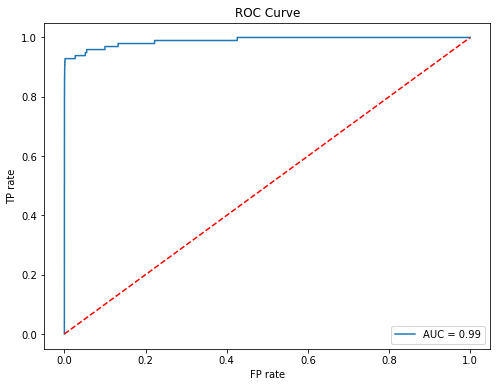

In [28]:
y_pred = model.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)

plt.figure(figsize=(8, 6))

plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")

plt.ylabel("TP rate")
plt.xlabel("FP rate")

plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

A standard approach for binary classification problems is to look at the probability produced by the model and classify the observation as class 0 if the probability is under 0.5, and class 1 if it is equal or over 0.5. In highly unbalanced datasets this interpretation could lead to poor predictions. Offsetting the threshold (threshold moving) is a standard technique for improving the predictions by finding an optimal interpretation of the probabilities produced by the classifier.

There is an extra factor that comes into play in fraud detection, which is that the cost of one type of misclassification is substantially higher than the other. In other words, classifing a legitimate transaction as fraud is inconvenient at best, but letting a fraudulent transaction slip through has more dire consequences. In this context, offsetting the threshold in a way that reduces the false negatives at the expense of false positives becomes a viable strategy.

Selecting the optimal threshold value can be performed in a number of ways. Looking at the ROC curve, we can intuitively see that the best performance (misclassification costs aside) would be yield by the threshold that puts us in the top left section of the curve (i.e. TP rate is high, FP rate is low). With this criterion in mind, we can define a distance metric to the top left corner of the curve and find a threshold that minimises it.

$T_{optimal} = \text{argmax}_t \sqrt{TP_r - FP_r}$

In [29]:
t_opt_idx = np.argmax(tp_r - fp_r)
t_opt = t[t_opt_idx]
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.80


We can also manually inspect the confusion matrices at different threshold values.

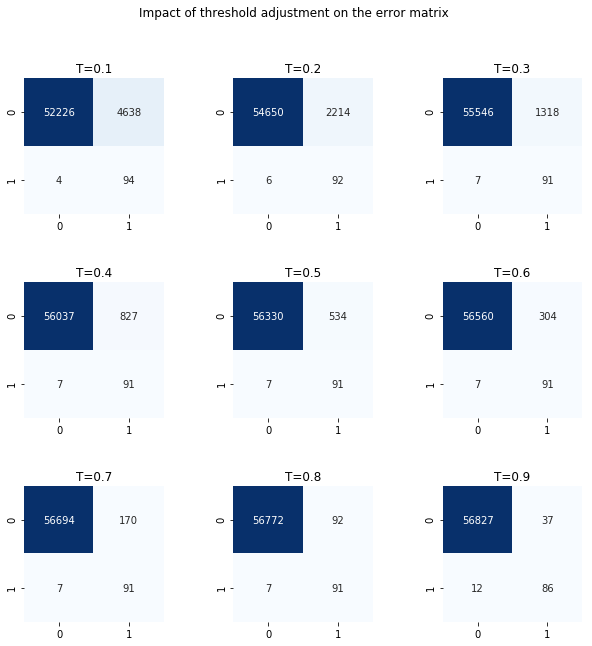

In [30]:
y_pred = model.predict_proba(X_test)[:,1]

fig, axes = plt.subplots(3,3, figsize=(10,10))
    
for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10

    y_pred_int = (y_pred > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix");

#### 

Looking at the plot above, we can indeed confirm that T=0.8 gives the best interpretation. The false negatives and false positives are both low. Increasing the threshold further leads to missing more fraudulent transactions, and reducing it lower almost doubles the number false positives.

## Persisting the trained model <a name="persisting"></a>

Now that we are satisfied with how the model performs, we can persist it and use it from other notebooks / scoring scripts.

In [31]:
model.save_model("./model/smote_fraud.xgb")

Loading the persisted model can be acomplished with just a few lines of code. The following lines are intentionally commented out, as we don't need to do this for this notebook.

In [32]:
#model = XGBClassifier()
#booster = Booster()
#booster.load_model('./model/smote_fraud.xgb')
#model._Booster = booster

## Summary <a name="summary"></a>

In this notebook we looked at a real-world credit card transaction dataset and demonstrated how machine learning can be used to automate the detection of fraudulent transactions. The model can be automatically updated as new data comes in, and the re-training process doesn't require human intervention. 

The imbalance in the dataset can be addressed by using under/oversampling techniques, and the interpretation of the probabilities can be fine-tuned to produce a better balance between false alarms and missed fraudulent transactions. For a more formal overview of the implications and techniques around imbalanced learning, you can look at [[3]](#ref3)

## References <a name="ref"></a>

<a id="ref1"></a>
[1] Jose M. Pavía, Ernesto J. Veres-Ferrer, Gabriel Foix-Escura, [Credit card incidents and control systems](https://www.sciencedirect.com/science/article/abs/pii/S0268401212000436), International Journal of Information Management, Volume 32, Issue 6, 2012, Pages 501-503, ISSN 0268-4012

<a id="ref2"></a>
[2] Nitesh V. Chawla, Kevin W. Bowyer, Lawrence O. Hall, and W. Philip Kegelmeyer. 2002. [SMOTE: synthetic minority over-sampling technique](https://arxiv.org/pdf/1106.1813.pdf). J. Artif. Int. Res. 16, 1 (January 2002), 321–357.

<a id="ref3"></a>
[3] He, H. & Garcia, E. (2009). [Learning from Imbalanced Data](https://ieeexplore.ieee.org/document/5128907). Knowledge and Data Engineering, IEEE Transactions on, 21, 1263-1284. doi: 10.1109/TKDE.2008.239